# Process gridded observation data into timeseries

__1. Process the gridded temperature data into timeseries for each observational product.__

Output is a dataArray for each model with dimensions of time and IPCC region containing a time series of the TAS variable.


Use this tool:  

https://github.com/IPCC-WG1/Atlas/blob/main/notebooks/reference-regions_Python.ipynb

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

## Code!

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

%matplotlib inline

__Observational Large Ensembles.__

General directory in Nathan's scratch: /glade/scratch/lenssen/data_for_jonah/

NASA GISTEMP: GISTEMP_2x2  GISTEMP_5x5

HadCRUT5: HadCRUT5

In [2]:
gistemp_2x2_dir = '/glade/scratch/lenssen/data_for_jonah/GISTEMP_2x2/'
gistemp_5x5_dir = '/glade/scratch/lenssen/data_for_jonah/GISTEMP_5x5/'
hadcrut5_dir    = '/glade/scratch/lenssen/data_for_jonah/HadCRUT5/'

### Collect file paths.

#### Collect GISTEMP 2x2 file paths.

In [3]:
gistemp_2x2_files = glob.glob('%s/ensembleChunk_???.nc' % gistemp_2x2_dir)
gistemp_2x2_files.sort()

#### Collect GISTEMP 5x5 file paths.

In [4]:
gistemp_5x5_files = glob.glob('%s/ensembleChunk_5x5_???.nc' % gistemp_5x5_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [5]:
hadcrut5_files = glob.glob('%s/HadCRUT.5.0.1.0.analysis.anomalies.*.nc' % hadcrut5_dir)
hadcrut5_files.sort()

### Load and process timeseries according to IPCC Region designations.

#### 1. Visualize the IPCC AR6 regions

In [6]:
import regionmask

regionmask.__version__

'0.9.0'

In [7]:
import cartopy.crs as ccrs
import matplotlib.patheffects as pe

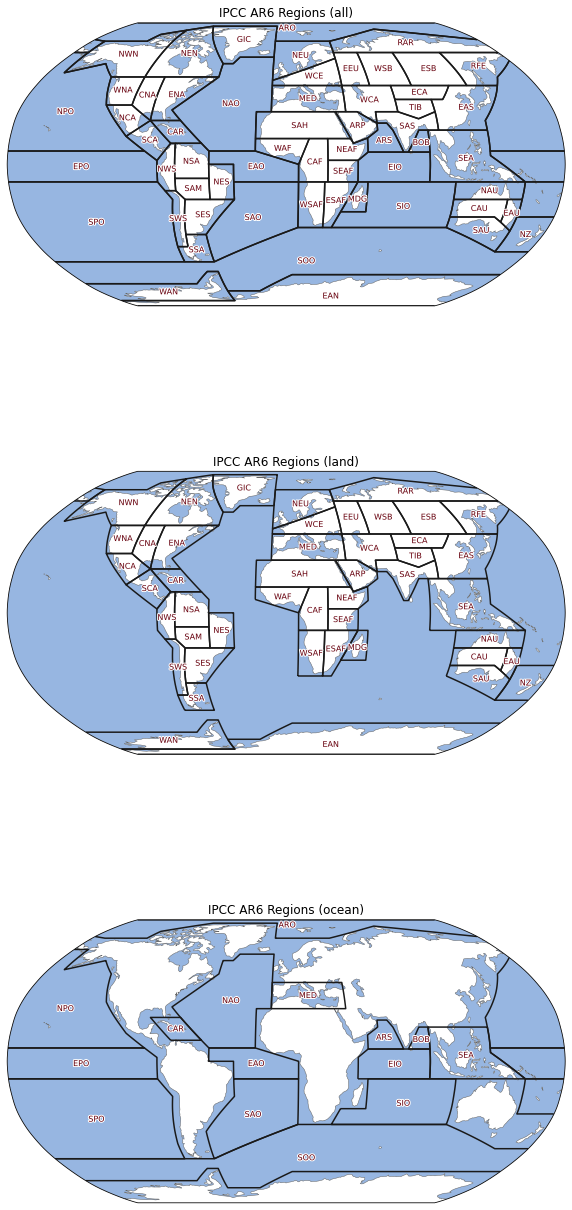

In [8]:
ipcc_ar6_regions_all   = regionmask.defined_regions.ar6.all
ipcc_ar6_regions_land  = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_ocean = regionmask.defined_regions.ar6.ocean

text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=8,
)

_fig,_axs = plt.subplots(3,1,figsize=(10,24),subplot_kw={'projection':ccrs.Robinson()})
_fig.subplots_adjust(hspace=0.1)

_axs[0].set_title('IPCC AR6 Regions (all)')
_axs[1].set_title('IPCC AR6 Regions (land)')
_axs[2].set_title('IPCC AR6 Regions (ocean)')

ax = ipcc_ar6_regions_all.plot(ax = _axs[0],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

ax = ipcc_ar6_regions_land.plot(ax = _axs[1],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

ax = ipcc_ar6_regions_ocean.plot(ax = _axs[2],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

### 3. Do masking for a single file and region

#### GISTEMP 2x2

Variable is "tempAnom". "record" coordinate will allow for easier concatenation.

In [9]:
gistemp_tas_var = 'tempAnom'

In [10]:
ex_gistemp_2x2_filepath = gistemp_2x2_files[0]
ex_gistemp_2x2_ds       = xr.open_dataset(ex_gistemp_2x2_filepath)

In [11]:
ex_gistemp_2x2_ds

<xarray.Dataset>
Dimensions:   (lat: 90, lon: 180, record: 10, time: 1692)
Coordinates:
  * lon       (lon) int32 -179 -177 -175 -173 -171 -169 ... 171 173 175 177 179
  * lat       (lat) int32 -89 -87 -85 -83 -81 -79 -77 ... 77 79 81 83 85 87 89
  * time      (time) int32 1880 1880 1880 1880 1880 ... 2020 2020 2020 2020 2020
  * record    (record) int32 1 2 3 4 5 6 7 8 9 10
Data variables:
    tempAnom  (record, time, lat, lon) float32 ...
Attributes:
    title:        UncertaintyEnsemble
    institution:  NASA GISTEMP
    history:      N. Lenssen, Fri Apr 14 14:04:46 2023

#### GISTEMP 5x5

Variable is "tempAnom"

There are different dimensions of bnds, time, time_2 here.

In [12]:
ex_gistemp_5x5_filepath = gistemp_5x5_files[0]
ex_gistemp_5x5_ds       = xr.open_dataset(ex_gistemp_5x5_filepath)

In [13]:
ex_gistemp_5x5_ds

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 36, longitude: 72, time: 10, time_2: 1692)
Coordinates:
  * time            (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * time_2          (time_2) int32 1880 1880 1880 1880 ... 2020 2020 2020 2020
Dimensions without coordinates: bnds
Data variables:
    longitude_bnds  (longitude, bnds) float64 ...
    latitude_bnds   (latitude, bnds) float64 ...
    tempAnom        (time, time_2, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  NASA GISTEMP
    title:        UncertaintyEnsemble
    history:      Mon May 08 15:30:48 2023: cdo remapcon,/Users/nale4362/Docu...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

#### HadCRUT5

Variable is "tas".

This has a "realization" coordinate that should make concatenation easier. Is 5x5 degree resolution.

In [14]:
hadcrut5_tas_var = 'tas'

In [15]:
ex_hadcrut5_filepath = hadcrut5_files[0]
ex_hadcrut5_ds       = xr.open_dataset(ex_hadcrut5_filepath)

In [16]:
ex_hadcrut5_ds

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 36, longitude: 72, time: 2078)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-02-15
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
    realization     int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas             (time, latitude, longitude) float64 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2023-04-13T10:37:48+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

#### Create masks

In [17]:
mask_gistemp_2x2 = regionmask.defined_regions.ar6.all.mask(ex_gistemp_2x2_ds[gistemp_tas_var])
mask_gistemp_5x5 = regionmask.defined_regions.ar6.all.mask(ex_gistemp_5x5_ds[gistemp_tas_var],lon_name='longitude',lat_name='latitude')
mask_hadcrut5    = regionmask.defined_regions.ar6.all.mask(ex_hadcrut5_ds[hadcrut5_tas_var],lon_name='longitude',lat_name='latitude')

### Loop over observation files and compute the regional means.

In [18]:
def create_ipccregion_timeseries(_ds_filepath:str,_ds_var:str,regions:regionmask.Regions,cesm=False,ufunc=None,
                                 lon=None,lat=None,lon_name='lon',lat_name='lat'):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    '''
    # Load data
    ds      = xr.open_dataset(_ds_filepath,chunks={lat_name:-1,lon_name:-1})
    
    # Correct time if CESM
    if cesm:
        ds  = fix_cesm_time(ds)
    
    da      = ds[_ds_var]
    
    if (ufunc is not None):
        da = ufunc(da) #.sel(time=slice(1960,None))
    # da = da.chunk(chunks={'lat':-1,'lon':-1,'record':1}) # JKS speed-up attempt
    
    # Generate mask
    if ((lon is not None) and (lat is not None)):
        print('Using "lat" and "lon" supplied as input')
        
        # Make sure the passed grid values match the data approximately.
        np.testing.assert_allclose(lat,da['lat'],atol=5e-2,rtol=1e-1,err_msg='Supplied latitudes do not match data')
        np.testing.assert_allclose(lon,da['lon'],atol=5e-2,rtol=1e-1,err_msg='Supplied longitudes do not match data')
        
        mask    = regions.mask(lon,lat=lat)
        
        da['lon'] = lon
        da['lat'] = lat
        
    else:
        mask    = regions.mask(da)
    
    # Get unique region indices
    reg     = np.unique(mask.values)
    reg     = reg[~np.isnan(reg)]
    
    # for metadata: find abbreviations of all regions that were selected
    abbrevs = regions[reg].abbrevs
    names   = regions[reg].names
    
    # Compute weights for entire grid
    weights = np.cos(np.deg2rad(da.lat)) # assuming 'lat' used consistently
    
    # Iterate over regions and compute a weighted time series
    region_timeseries = []
    for i,_abbrev,_name in zip(reg,abbrevs,names):
        
        _region = da.where(mask == i)
        
        _region_avg = _region.weighted(weights).mean(dim=("lat", "lon")) # - 273.15
                
        # Using an int here should help with subsetting later.
        _region_avg = _region_avg.assign_coords({'RegionIndex':int(i)}).expand_dims('RegionIndex',axis=-1)

        # Include region abbreviation and name for easier use later
        _region_avg = _region_avg.assign_coords({'RegionAbbrev':_abbrev})
        _region_avg = _region_avg.assign_coords({'RegionName':_name})
        
        region_timeseries.append(_region_avg)
        
    region_timeseries_ds = xr.concat(region_timeseries,dim='RegionIndex')
    region_timeseries_ds.name = _ds_var
        
    return region_timeseries_ds

In [19]:
save_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

#### GISTEMP 2x2

In [20]:
# Arbitrary function to apply

def gistemp_2x2_tselect(da:xr.DataArray):
    
    return da.sel(time=slice(1960,None))

In [21]:
%%time

model_subdir = 'GISTEMP_2x2/'

# Variable to select and operate over.
_ds_var = gistemp_tas_var

for _ds_filepath in gistemp_2x2_files:
    # break
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=False,
                                                             ufunc=gistemp_2x2_tselect
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    break
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)

CPU times: user 39.5 s, sys: 12 s, total: 51.5 s
Wall time: 55.6 s


In [22]:
ex_gistemp_2x2_tseries = _regional_tseries

#### GISTEMP 5x5

The coordinate labelling here is kind of weird and harder to work with.

In [23]:
# Arbitrary function to apply

def gistemp_5x5_tselect(da:xr.DataArray):
    
    return da.sel(time_2=slice(1960,None)).rename({'longitude':'lon','latitude':'lat'})

In [24]:
%%time

model_subdir = 'GISTEMP_5x5/'

# Variable to select and operate over.
_ds_var = gistemp_tas_var

for _ds_filepath in gistemp_5x5_files:
    # break
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=False,
                                                             ufunc=gistemp_5x5_tselect,
                                                             lon_name='longitude',
                                                             lat_name='latitude',
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    break
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)

CPU times: user 6.66 s, sys: 1.77 s, total: 8.42 s
Wall time: 8.92 s


In [25]:
ex_gistemp_5x5_tseries = _regional_tseries

#### HadCRUT5

In [26]:
# Arbitrary function to apply

def hadcrut5_tselect(da:xr.DataArray):
    
    return da.sel(time=slice('1960-01-01','2022-12-31')).rename({'longitude':'lon','latitude':'lat'})

In [27]:
%%time

model_subdir = 'HadCRUT5/'

# Variable to select and operate over.
_ds_var = hadcrut5_tas_var

for _ds_filepath in hadcrut5_files:
    # break
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=False,
                                                             ufunc=hadcrut5_tselect,
                                                             lon_name='longitude',
                                                             lat_name='latitude',
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    break
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)

CPU times: user 1.67 s, sys: 26.6 ms, total: 1.7 s
Wall time: 1.84 s


In [28]:
ex_hadcrut5_tseries = _regional_tseries

#### Plot for sanity before fully processing.

There appears to be great agreement between all of the datasets, which is comforting.

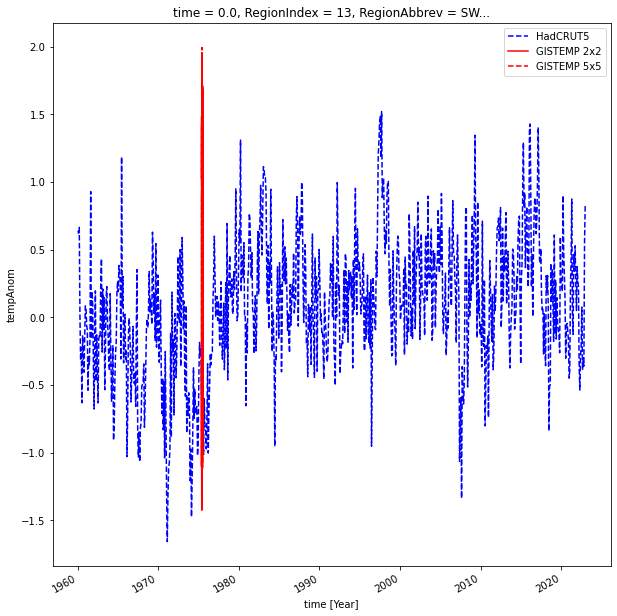

In [53]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

region_index = 13

ex_hadcrut5_tseries.sel(RegionIndex=region_index).plot(color='blue',label='HadCRUT5',linestyle='dashed',ax=ax)

ex_gistemp_2x2_tseries.sel(RegionIndex=region_index,record=1).plot(color='red',label='GISTEMP 2x2',ax=ax)

ex_gistemp_5x5_tseries.sel(RegionIndex=region_index).isel(time=0).plot(color='red',label='GISTEMP 5x5',linestyle='dashed',ax=ax)

plt.legend()

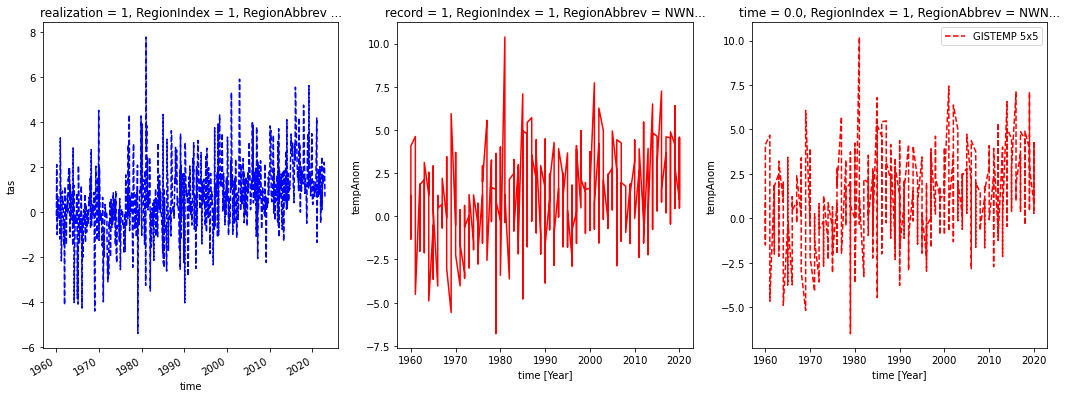

In [49]:
fig,axs = plt.subplots(1,3,figsize=(18,6))

region_index = 1

ex_hadcrut5_tseries.sel(RegionIndex=region_index).plot(color='blue',label='HadCRUT5',linestyle='dashed',ax=axs[0])

ex_gistemp_2x2_tseries.sel(RegionIndex=region_index,record=1).plot(color='red',label='GISTEMP 2x2',ax=axs[1])

ex_gistemp_5x5_tseries.sel(RegionIndex=region_index).isel(time=0).plot(color='red',label='GISTEMP 5x5',linestyle='dashed',ax=axs[2])

plt.legend()

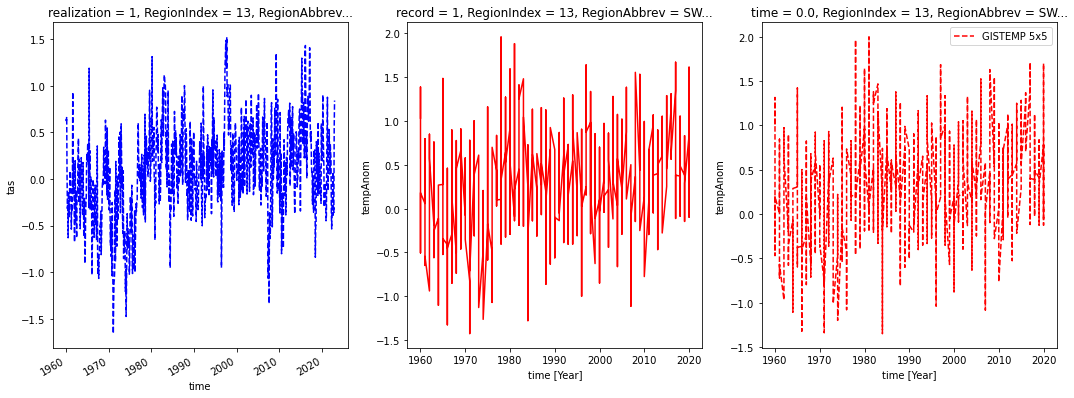

In [54]:
fig,axs = plt.subplots(1,3,figsize=(18,6))

region_index = 13

ex_hadcrut5_tseries.sel(RegionIndex=region_index).plot(color='blue',label='HadCRUT5',linestyle='dashed',ax=axs[0])

ex_gistemp_2x2_tseries.sel(RegionIndex=region_index,record=1).plot(color='red',label='GISTEMP 2x2',ax=axs[1])

ex_gistemp_5x5_tseries.sel(RegionIndex=region_index).isel(time=0).plot(color='red',label='GISTEMP 5x5',linestyle='dashed',ax=axs[2])

plt.legend()

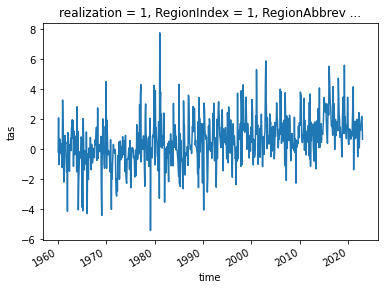

In [97]:
_regional_tseries.sel(RegionIndex=1).plot()

#### CESM1-CAM5 (CESM1-LE)

In [23]:
model_subdir = 'CESM1/'

# Variable to select and operate over.
_ds_var = cesm1_cmor_var_dict['tas']

for _ds_filepath in cesm1_pic_path_dict['tas']:
    # break
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=True,
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    break
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)

Create mask.

In [14]:
regionmask.defined_regions.ar6.land

<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)
overlap:  False

Regions:
  0  GIC  Greenland/Iceland
  1  NWN  N.W.North-America
  2  NEN  N.E.North-America
  3  WNA    W.North-America
  4  CNA    C.North-America
..   ...                ...
 41  EAU        E.Australia
 42  SAU        S.Australia
 43   NZ        New-Zealand
 44  EAN       E.Antarctica
 45  WAN       W.Antarctica

[46 regions]

In [15]:
mask = regionmask.defined_regions.ar6.land.mask(ex_tas_da)

In [16]:
mask_fake = regionmask.defined_regions.ar6.land.mask(mpi_lons,mpi_lats)

In [ ]:
# mask_mpi = regionmask.defined_regions.ar6.land.mask(ex_mpi_tas_ds) # kills the kernel!

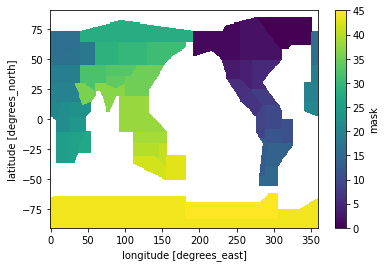

In [18]:
mask.plot()

In [16]:
mask

<xarray.DataArray 'mask' (lat: 192, lon: 288)>
array([[44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

Oh cool! The mask has the value corresponding to the region's index?

In [17]:
# for colorbar: find abbreviations of all regions that were selected
reg = np.unique(mask.values)
reg = reg[~np.isnan(reg)]
abbrevs = regionmask.defined_regions.ar6.land[reg].abbrevs
names   = regionmask.defined_regions.ar6.land[reg].names

The CNA (central north america) region is index 4.

In [18]:
CNA_index = regionmask.defined_regions.ar6.land.map_keys("C.North-America")

In [19]:
# Mask out (in) a region
airtemps_CNA = ex_tas_da.where(mask == CNA_index)

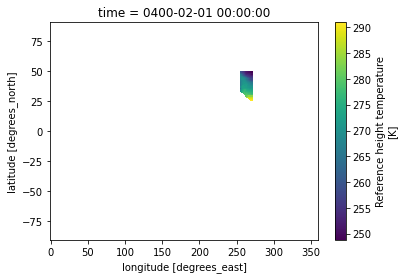

In [20]:
airtemps_CNA.isel(time=0).plot()

In [21]:
weights = np.cos(np.deg2rad(airtemps_CNA.lat))

ts_airtemps_CNA = airtemps_CNA.weighted(weights).mean(dim=("lat", "lon")) - 273.15

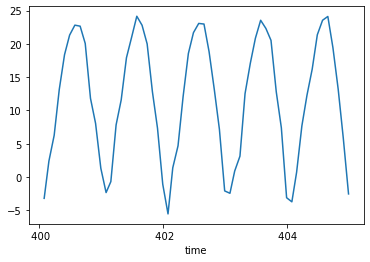

In [22]:
ts_airtemps_CNA.isel(time=slice(None,60)).plot()

### Write a function to compute timeseries for all IPCC AR6 regions when given a simple model output file.

In [23]:
# Filepath to a netcdf dataset.
_ds_filepath = cesm1_pic_path_dict['tas'][0]

# Variable to select and operate over.
_ds_var = cesm1_cmor_var_dict['tas']

In [24]:
def create_ipccregion_timeseries(_ds_filepath:str,_ds_var:str,regions:regionmask.Regions):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    '''

    # Load data
    ds      = xr.open_dataset(_ds_filepath,chunks={'lat':-1,'lon':-1}) 
    da      = ds[_ds_var]
    
    # Generate mask
    mask    = regions.mask(da)
    
    # Get unique region indices
    reg     = np.unique(mask.values)
    reg     = reg[~np.isnan(reg)]
    
    # for metadata: find abbreviations of all regions that were selected
    abbrevs = regions[reg].abbrevs
    names   = regions[reg].names
    
    # Compute weights for entire grid
    weights = np.cos(np.deg2rad(da.lat)) # assuming 'lat' used consistently
    
    # Iterate over regions and compute a weighted time series
    region_timeseries = []
    for i,_abbrev,_name in zip(reg,abbrevs,names):
        
        _region = da.where(mask == i)
        
        _region_avg = _region.weighted(weights).mean(dim=("lat", "lon")) # - 273.15
                
        # Using an int here should help with subsetting later.
        _region_avg = _region_avg.assign_coords({'RegionIndex':int(i)}).expand_dims('RegionIndex',axis=-1)

        # Include region abbreviation and name for easier use later
        _region_avg = _region_avg.assign_coords({'RegionName':_abbrev})
        _region_avg = _region_avg.assign_coords({'RegionAbbrev':_name})
        
        region_timeseries.append(_region_avg)
        
    region_timeseries_ds = xr.concat(region_timeseries,dim='RegionIndex')
        
    return region_timeseries_ds

In [25]:
%%time

out = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,_ds_var=_ds_var,regions=regionmask.defined_regions.ar6.land)

CPU times: user 781 ms, sys: 8.3 ms, total: 789 ms
Wall time: 804 ms


In [26]:
%%time

# Everything is delayed, so the real computations take a bit longer (30s for 100 years of CESM1 data, not bad!)
testout = out.compute()

CPU times: user 19.7 s, sys: 11 s, total: 30.7 s
Wall time: 31.8 s


Test it!

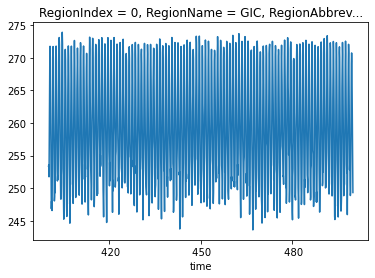

In [27]:
testout.sel(RegionIndex=0).plot()

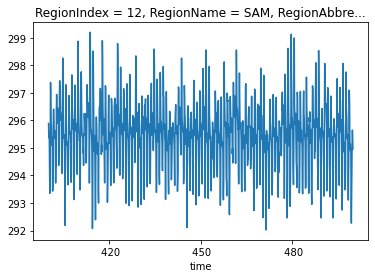

In [28]:
testout.sel(RegionIndex=12).plot()